# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [148]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize
from sklearn.tree import DecisionTreeRegressor

In [346]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.trees = []
        self.gamma = 1
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()
        y_new = 0
        for i in range(0, self.n_estimators):
            y_new += self._fit_predict_tree(x, y - y_new)

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        tree = DecisionTreeRegressor(max_depth=self.max_depth)
        tree.fit(x, y)
        self.trees.append(tree)
        return self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        y_pred = 0
        for i in self.trees:
            y_pred += self.gamma * self.learning_rate * i.predict(x)
        return y_pred

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [347]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [348]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=4, n_estimators=640, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

9.63198271791959

In [399]:
np.random.seed(19052019)

gb = GradientBoosting(44, 6, 0.248908)
gb.fit(X_train, y_train)
mean_squared_error(y_test, gb.predict(X_test))

9.544619716488949

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Нет

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [141]:
df_train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [142]:
import catboost
from catboost import *

In [143]:
df_train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [144]:
y = df_train['dep_delayed_15min'].map({'Y': 1, 'N': 0})
X = df_train.drop('dep_delayed_15min', axis=1)

In [145]:
cat_features = [0, 1, 2, 4, 5, 6]
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

In [146]:
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics
model = CatBoostClassifier(
    random_seed=42,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [147]:
roc_auc_score(y_validation, model.predict_proba(X_validation)[:, 1])

0.7481217789512494

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [180]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [365]:
# Рекомендации -- это только рекомендации
import collections
from collections import deque
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        
    def fit_predict(self, X):
        # Помечаем переданные точки, чтобы отличать уже кластеризованные
        # или являющиеся шумом от остальных
        self.points = X
        self.last_cluster = 0
        self.clusters = {}
        for i in self.points:
            self.clusters[tuple(i)] = -1
        
        # Реализуем цикл по точкам, игнорирущий уже кластеризованные
        
        # Если точка ещё не кластеризована, с помощью range_query() ищем её соседей
        # Если соседей недостаточно, то помечаем её выделенным под шум лейблом
        # (однако она ещё может попасть в какой-то иной кластер)
        # Если же соседей достаточно, будем строить от неё кластер с помощью grow_cluster()
        for i in self.points:
            neighbours = self.range_query(i)
            if self.clusters[tuple(i)] == -1 and len(neighbours) >= self.min_samples:
                self.grow_cluster(i)
                self.last_cluster += 1
                
        for i in self.points:
            if self.clusters[tuple(i)] == -1:
                neighbours = self.range_query(i)
                if len(neighbours) > 1:
                    for j in neighbours:
                        if self.clusters[tuple(j)] != -1:
                            self.clusters[tuple(i)] = self.clusters[tuple(j)]
                            break
        
        return list(self.clusters.values())

    def grow_cluster(self, root):
        # В этой функции мы полностью строим кластер относительно переданной точки
        # Т.е. реализуем цикл по структуре данных, изначально состоящей из уже
        # известных соседей (neighbours) и в процессе пополняющейся
        # "соседями соседей" с помощью range_query()
        q = deque()
        q.append(root)
        self.clusters[tuple(root)] = self.last_cluster
        while q:
            v = q.popleft()
            neighbours = self.range_query(v)
            for i in neighbours:
                if self.clusters[tuple(i)] == -1 and len(self.range_query(i)) >= self.min_samples:
                    q.append(i)
                    self.clusters[tuple(i)] = self.last_cluster
        

    def range_query(self, x):
        """Возвращает точки на расстоянии <= eps от x"""
        # С помощью функции dist()
        neighbours = []
        for i in self.points:
            if self.dist(x, i) <= self.eps:
                neighbours.append(i)
        return neighbours
    
    @staticmethod
    def dist(a, b):
        """Метрика расстояния"""
        # Попробуйте что-нибудь из scipy.spatial.distance
        # Базовый вариант -- Евклидова метрика
        return distance.cdist([a], [b], 'euclidean')[0][0]

Проверим себя на простом примере:

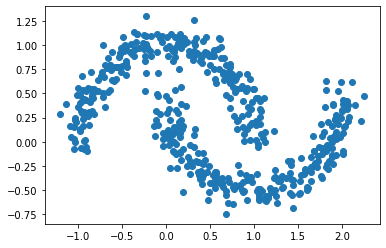

In [356]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

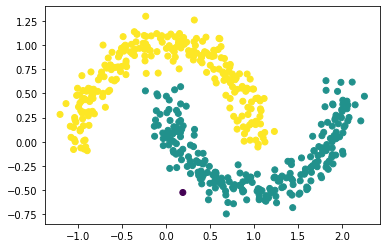

In [357]:
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)
plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

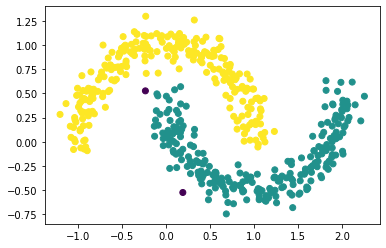

In [358]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

In [359]:
dino = pd.read_csv('/Users/dariaeremina/Downloads/DatasaurusDozen.tsv', sep='\t')
dino = dino.loc[dino['dataset'] == 'dino']
dino.head()

,dataset,x,y
0,dino,55.3846,97.1795
1,dino,51.5385,96.0256
2,dino,46.1538,94.4872
3,dino,42.8205,91.4103
4,dino,40.7692,88.3333


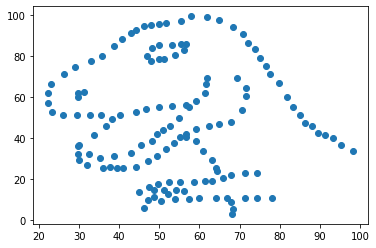

In [360]:
dino_points = []
for index, row in dino.iterrows():
    dino_points.append([row['x'], row['y']])
dino_points = np.array(dino_points)
plt.scatter(dino_points[:,0], dino_points[:,1])
plt.show()

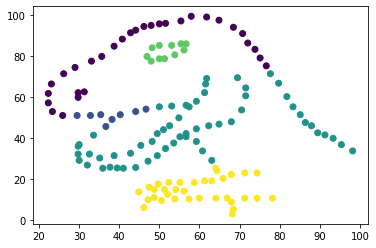

In [361]:
clusters = dbscan(eps=9, min_samples=7).fit_predict(dino_points)
plt.scatter(dino_points[:,0], dino_points[:,1], c=clusters)
plt.show()

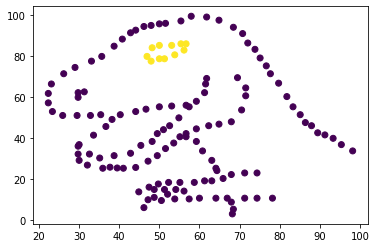

In [362]:
clusters = dbscan(eps=8, min_samples=2).fit_predict(dino_points)
plt.scatter(dino_points[:,0], dino_points[:,1], c=clusters)
plt.show()

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [363]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 6.45 ms, sys: 7.71 ms, total: 14.2 ms
Wall time: 13.2 ms


In [366]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 8.69 s, sys: 33.1 ms, total: 8.72 s
Wall time: 8.76 s
